# 신경망

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print ("Training examples summary:")
display.display(training_examples.describe())
print ("Validation examples summary:")
display.display(validation_examples.describe())

print ("Training targets summary:")
display.display(training_targets.describe())
print ("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2646.4,540.7,1433.7,502.6,3.9,2.0
std,2.1,2.0,12.6,2163.9,420.5,1148.5,384.0,1.9,1.2
min,32.5,-124.3,2.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1465.0,298.0,792.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2127.0,435.0,1165.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3156.2,650.0,1726.0,605.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2637.0,536.4,1419.8,497.8,3.9,2.0
std,2.1,2.0,12.6,2218.1,423.9,1146.3,385.8,1.9,1.1
min,32.6,-124.3,1.0,18.0,3.0,8.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1453.0,294.0,782.0,277.0,2.6,1.5
50%,34.2,-118.5,29.0,2128.5,431.0,1170.0,407.5,3.6,1.9
75%,37.7,-118.0,37.0,3138.8,646.2,1712.0,606.0,4.8,2.3
max,41.9,-114.6,52.0,32627.0,6445.0,28566.0,6082.0,15.0,29.4


Training targets summary:


,median_house_value
count,12000.0
mean,207.0
std,115.8
min,15.0
25%,119.8
50%,179.4
75%,264.0
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.0
std,116.4
min,15.0
25%,119.1
50%,182.2
75%,267.4
max,500.0


## 신경망 구축

NN은 $\textbf{DNNRegressor}$ 클래스에 의해 정의됩니다.

hidden_units를 사용하여 NN의 구조를 정의합니다. hidden_units 인수는 정수의 목록을 제공하며, 각 정수는 히든 레이어에 해당하고 포함된 노드의 수를 나타냅니다. 예를 들어 아래 대입식을 살펴보세요.

hidden_units=[3,10]

위 대입식은 히든 레이어 2개를 갖는 신경망을 지정합니다.

- 1번 히든 레이어는 노드 3개를 포함합니다.
- 2번 히든 레이어는 노드 10개를 포함합니다.
레이어를 늘리려면 목록에 정수를 더 추가하면 됩니다. 예를 들어 hidden_units=[10,20,30,40]은 각각 10개, 20개, 30개, 40개의 유닛을 갖는 4개의 레이어를 만듭니다.

기본적으로 모든 히든 레이어는 ReLu 활성화를 사용하며 완전 연결성을 갖습니다.

In [5]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print ("Training model...")
  print ("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print ("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print ("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print ("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print ("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

## 작업 실행 1

Training model...
RMSE (on training data):
  period 00 : 238.26
  period 01 : 238.01
  period 02 : 236.20
  period 03 : 236.03
  period 04 : 235.89
  period 05 : 235.76
  period 06 : 235.64
  period 07 : 235.53
  period 08 : 235.43
  period 09 : 235.33
Model training finished.
Final RMSE (on training data):   235.33
Final RMSE (on validation data): 236.43


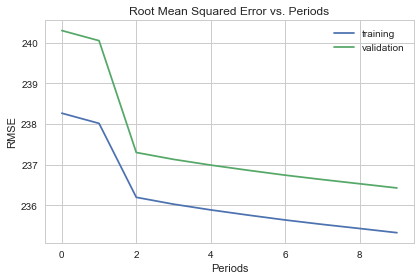

In [8]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 104.19
  period 01 : 99.07
  period 02 : 96.33
  period 03 : 98.99
  period 04 : 93.86
  period 05 : 93.50
  period 06 : 94.47
  period 07 : 91.98
  period 08 : 91.98
  period 09 : 92.03
Model training finished.
Final RMSE (on training data):   92.03
Final RMSE (on validation data): 93.51


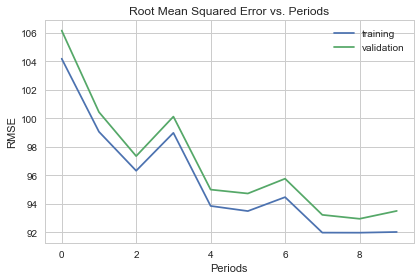

In [9]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## 작업 2 테스트 데이터

In [10]:
california_housing_test_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print ("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 90.54
